In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.interpolate import UnivariateSpline

sns.set_context('paper', font_scale=1.5)
sns.set_palette('colorblind')

import nudetect
H119_dir = '/Volumes/Samsung_1TB/detectorData/H119/'
plot_dir = H119_dir + 'figures/'
save_dir = H119_dir + 'data_products/'

In [2]:
H119 = nudetect.Detector('H119', offset=np.zeros((32,32,16)))
Am241 = nudetect.Source('Am241')
Eu155 = nudetect.Source('Eu155')
noise_exp = nudetect.Noise(H119_dir + '20190624_H119_noise_5C/20190624_H119_noise_5C.fits', \
                           'H119', 5, pos=0, data_dir=save_dir, plot_dir=plot_dir)
Am241_flood = nudetect.GammaFlood(H119_dir + 'floodAm241_5C_-500V_20190815_small_region_capoffset_corrected.fits',\
                               'H119', Am241, 500, 5, data_dir=save_dir, plot_dir=plot_dir, region = [[14,12],[19,17]])
Eu155_flood = nudetect.GammaFlood(H119_dir + 'floodEu155_5C_-500V_20190816_small_region_capoffset_corrected.fits',\
                               'H119', Eu155, 500, 5, data_dir=save_dir, plot_dir=plot_dir, region = [[14,12],[19,17]])

noise_exp = H119.add_experiment(noise_exp)
Am241_flood = H119.add_experiment(Am241_flood)
Eu155_flood = H119.add_experiment(Eu155_flood)
H119.print_experiments()


Noise5C
GammaAm2415C500V
GammaEu1555C500V


Computing PH_COM column for each gamma flood data set (if necessary)
Computing PH_COM column for each gamma flood data set (if necessary)
It looks like the gain has not been calculated. Generating the gain now...


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.10s/it]


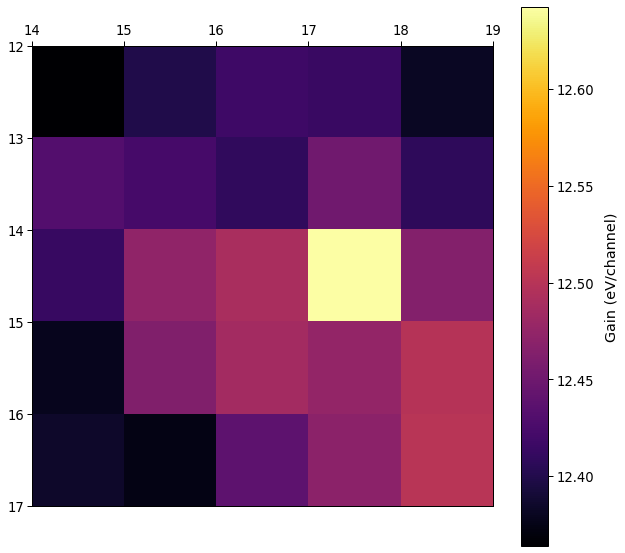

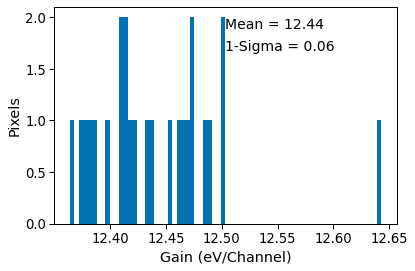

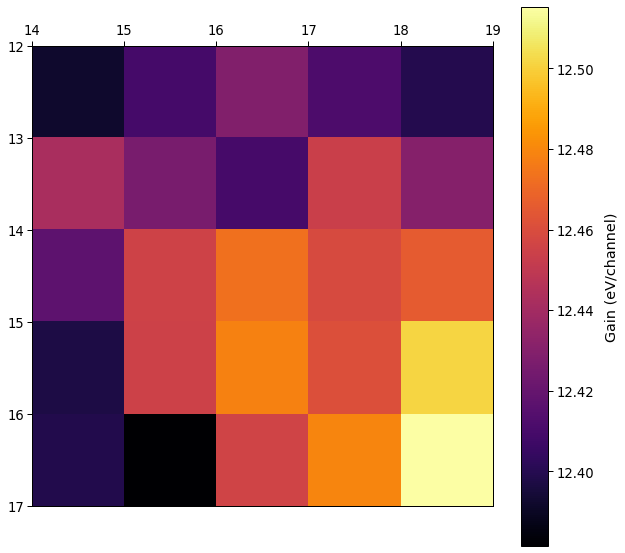

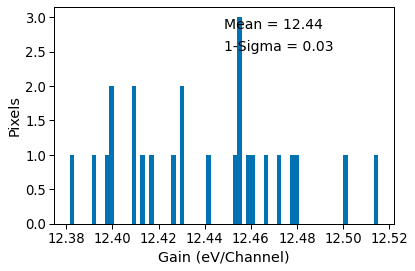

In [3]:
am_spectrum, eu_spectrum = H119.gen_calibrated_spectrum((Am241_flood, Eu155_flood), exclude_edges=False, grade_cut=0)

In [4]:
plt.ion()
plt.figure(figsize = (9,6))
plt.plot(am_spectrum[1], am_spectrum[0]/np.max(am_spectrum[0]), label=r'$^{241}\mathrm{Am}$')
plt.plot(eu_spectrum[1], eu_spectrum[0]/np.max(eu_spectrum[0]), label=r'$^{155}\mathrm{Eu}$')
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.xlim(0.0,110.)
plt.tight_layout()
plt.savefig(plot_dir + 'Eu155_Am241_calibrated_spec_offset_grade0.pdf')
plt.close()
# plt.ylim(0,600) 

In [4]:
from astropy.modeling import models, fitting
def tie_stddevs(model):
    return model.stddev_0

def tie_stddevs3(model):
    return model.stddev_3

def tie_means(model):
    return model.mean_0

def tie_means3(model):
    return model.mean_3

def exp_tail(x, norm=1, mean=0, stddev=1, slope=1):
    return norm*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))

def exp_tail_deriv(x, norm=1, mean=0, stddev=1, slope=1):
    return [
        np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*np.sqrt(2*np.pi)) -\
            norm*slope*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*(x-mean)*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*stddev*np.sqrt(2*np.pi)),
        norm*(x-mean)*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))
    ]

# ExpTail = models.custom_model(exp_tail, fit_deriv=exp_tail_deriv)
ExpTail = models.custom_model(exp_tail)

def const_shelf(x, norm=1, mean=0, stddev=1):
    return norm*(1-scipy.stats.norm.cdf(x, mean, stddev))

def const_shelf_deriv(x, norm=1, mean=0, stddev=1):
    return [
        (1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev),
        norm*(x-mean)*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev**2)
    ]

# ConstShelf = models.custom_model(const_shelf, fit_deriv=const_shelf_deriv)
ConstShelf = models.custom_model(const_shelf)



# Eu155 86keV

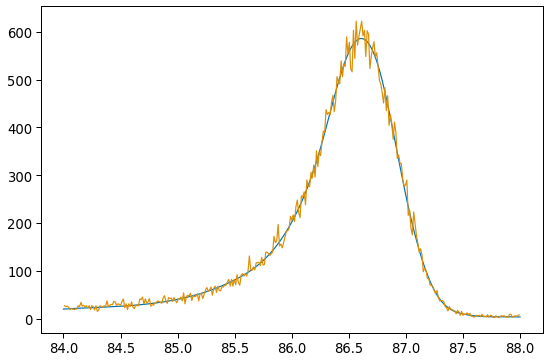

FWHM: 0.78976081391896
[2.30113074e+02 8.66695925e+01 2.68225850e-01 1.39007759e+01
 8.66695925e+01 2.68225850e-01 6.77493846e+02 8.66695925e+01
 2.68225850e-01 2.03190552e+00 3.77880557e+00]
None


In [18]:
upper=7400
lower=6850

line_init = models.Gaussian1D(amplitude=1600, mean=86.8, stddev=0.4) + ConstShelf(norm=60, mean=86.8, stddev=0.4) + \
    ExpTail(norm=1000, mean=86.8, stddev=0.4, slope=1.5) + models.Const1D(amplitude=20)

# line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
# line_init.norm_1.min = 0
# line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
# line_init.norm_2.min = 0
# line_init.norm_2.max = None

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, eu_spectrum[1][lower:upper], eu_spectrum[0][lower:upper], weights = 1/np.sqrt(eu_spectrum[0][lower:upper]))

xs = np.linspace(84, 88, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line.parameters[-1] - line(xs).max()/2)
roots = spline.roots() # find the roots

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(eu_spectrum[1][lower:upper], eu_spectrum[0][lower:upper], yerr=np.sqrt(eu_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(eu_spectrum[1][lower:upper], line(eu_spectrum[1][lower:upper]))

ax1.plot(eu_spectrum[1][lower:upper], line[0](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(eu_spectrum[1][lower:upper], line[1](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(eu_spectrum[1][lower:upper], line[2](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(eu_spectrum[1][lower:upper], line[3](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')
ax1.text(82.5, 400, r'Source: $^{155}$Eu')
ax1.text(82.5, 200, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
ax1.text(82.5, 100, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

ax2.errorbar(eu_spectrum[1][lower:upper], (eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper]))/np.sqrt(eu_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Eu155_grade0_86kev_fit.pdf')
plt.close()

# chisq_red = np.sum(((eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper])) ** 2)/\
#                    eu_spectrum[0][lower:upper])/len(eu_spectrum[0][lower:upper] - 7)
# print(chisq_red)


plt.figure(figsize=(9,6))
plt.plot(xs, spline(xs)+line(xs).max()/2 + line.parameters[-1])
plt.plot(eu_spectrum[1][np.abs(eu_spectrum[1] - 86) < 2],
         eu_spectrum[0][np.abs(eu_spectrum[1] - 86) < 2])
plt.show()
plt.close()
del xs, spline
print('FWHM: ' + str(roots[1] - roots[0]))

print(line.parameters)
print(line.stds)

# Eu155 105keV

/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_4245/1235852241.py:43: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(eu_spectrum[1][lower:upper], (eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper]))/np.sqrt(eu_spectrum[0][lower:upper]),
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_4245/1235852241.py:52: RuntimeWarning: divide by zero encountered in true_divide
  chisq_red = np.sum(((eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper])) ** 2)/\


inf
0.9670154488409679
[7.56914331e+01 1.05526623e+02 2.91941396e-01 1.29720875e+01
 1.05526623e+02 2.91941396e-01 3.88914227e+02 1.05526623e+02
 2.91941396e-01 1.72505741e+00]
None


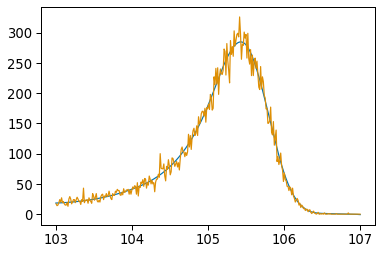

In [19]:
upper=8890
lower=8500
line_init = models.Gaussian1D(amplitude=50, mean=105, stddev=0.2) + ConstShelf(norm=1, mean=105, stddev=0.4) + \
        ExpTail(norm=10, mean=105, stddev=0.4, slope=.1)# + models.Const1D(amplitude=20)


# line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
# line_init.norm_1.min = 0
# line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
# line_init.norm_2.min = 0
# line_init.norm_2.max = None

zero_mask = eu_spectrum[0][lower:upper]!=0

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, eu_spectrum[1][lower:upper], eu_spectrum[0][lower:upper])

xs = np.linspace(103, 107, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(eu_spectrum[1][lower:upper], eu_spectrum[0][lower:upper], yerr=np.sqrt(eu_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(eu_spectrum[1][lower:upper], line(eu_spectrum[1][lower:upper]))

ax1.plot(eu_spectrum[1][lower:upper], line[0](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(eu_spectrum[1][lower:upper], line[1](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(eu_spectrum[1][lower:upper], line[2](eu_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')
ax1.text(102.2, 400, r'Source: $^{155}$Eu')
ax1.text(102.2, 200, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
ax1.text(102.2, 100, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')


ax2.errorbar(eu_spectrum[1][lower:upper], (eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper]))/np.sqrt(eu_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Eu155_grade0_105kev_fit.pdf')
plt.close()

chisq_red = np.sum(((eu_spectrum[0][lower:upper] - line(eu_spectrum[1][lower:upper])) ** 2)/\
                   eu_spectrum[0][lower:upper])/len(eu_spectrum[0][lower:upper] - 7)
print(chisq_red)


plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(eu_spectrum[1][np.abs(eu_spectrum[1] - 105) < 2],
         eu_spectrum[0][np.abs(eu_spectrum[1] - 105) < 2])
del xs, spline
print(roots[1] - roots[0])
print(line.parameters)
print(line.stds)


# Am241 59.5keV

/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_4245/350178889.py:40: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6355939763845058
[1.38974754e+02 5.95970838e+01 2.21727520e-01 1.18922633e+01
 5.95970838e+01 2.21727520e-01 9.50760742e+02 5.95970838e+01
 2.21727520e-01 3.83513682e+00]
[[ 2.06852126e+03  3.40623715e-01  1.19363077e-01 -1.39561707e+01
  -3.98295588e+03 -8.26381897e+00]
 [ 3.40623715e-01  8.36252823e-05  1.41918284e-05 -3.84135820e-03
  -6.45084830e-01 -1.67846240e-03]
 [ 1.19363077e-01  1.41918284e-05  8.86969700e-06 -6.67831395e-04
  -2.34246736e-01 -4.30087050e-04]
 [-1.39561707e+01 -3.84135820e-03 -6.67831395e-04  7.78995092e-01
   2.58680069e+01  8.17431984e-02]
 [-3.98295588e+03 -6.45084830e-01 -2.34246736e-01  2.58680069e+01
   7.69076082e+03  1.58255231e+01]
 [-8.26381897e+00 -1.67846240e-03 -4.30087050e-04  8.17431984e-02
   1.58255231e+01  3.72677579e-02]]


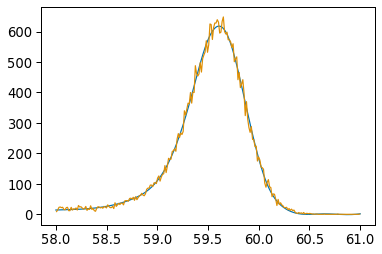

In [20]:
upper=5050
lower=4700

line_init = models.Gaussian1D(amplitude=150, mean=59.6, stddev=0.22) + ConstShelf(norm=11, mean=59.5, stddev=0.2) + \
    ExpTail(norm=920, mean=59.5, stddev=0.2, slope=3.7)# + models.Const1D(amplitude=20)

# line_init = models.Gaussian1D(amplitude=500, mean=59.5, stddev=0.2) + ConstShelf(norm=10, mean=59.5, stddev=0.2)


line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means

zero_mask = am_spectrum[0][lower:upper]!=0

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])

xs = np.linspace(58, 61, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')
ax1.text(56.6, 400, r'Source: $^{241}$Am')
ax1.text(56.6, 200, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
ax1.text(56.6, 100, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Am241_grade0_60kev_fit.pdf')
plt.close()


# chisq_red = np.sum(((am_spectrum[0][lower:upper][zero_mask] - line(am_spectrum[1][lower:upper][zero_mask])) ** 2)/\
#                    am_spectrum[0][lower:upper][zero_mask])/len(am_spectrum[0][lower:upper][zero_mask] - 7)
# print(chisq_red)


plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(am_spectrum[1][np.abs(am_spectrum[1] - 59.5) < 1.5],
         am_spectrum[0][np.abs(am_spectrum[1] - 59.5) < 1.5])
del xs, spline
print(roots[1] - roots[0])
print(line.parameters)
print(fit_line.fit_info['param_cov'])


# Am241 14keV

1.097459448873769
0.4790922421595951
[1.24401775e+02 1.39703129e+01 1.78793446e-01 2.49471995e+02
 1.39703129e+01 1.78793446e-01 3.62655973e+00 1.04064643e+01]
[[ 8.39681139e+02  1.95878848e-02  1.39896789e-01 -1.65984460e+03
  -1.17491838e+01 -1.45732618e+01]
 [ 1.95878848e-02  1.51324635e-05 -8.44009297e-07 -3.69132091e-02
  -6.04241381e-04 -1.39441166e-03]
 [ 1.39896789e-01 -8.44009297e-07  2.75707743e-05 -2.79719910e-01
  -1.91864242e-03 -2.63891294e-03]
 [-1.65984460e+03 -3.69132091e-02 -2.79719910e-01  3.29234198e+03
   2.32615888e+01  2.81885126e+01]
 [-1.17491838e+01 -6.04241381e-04 -1.91864242e-03  2.32615888e+01
   1.75121368e-01  2.43956057e-01]
 [-1.45732618e+01 -1.39441166e-03 -2.63891294e-03  2.81885126e+01
   2.43956057e-01  7.81160077e-01]]


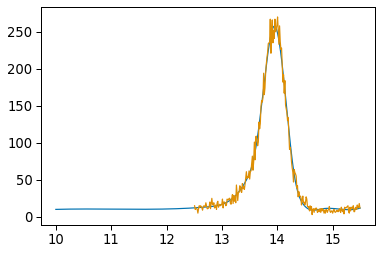

In [21]:
lower=1020
upper=1250

# line_init = models.Gaussian1D(amplitude=250, mean=13.9, stddev=0.3) + ConstShelf(norm=1, mean=13.9, stddev=0.2) + models.Const1D(amplitude=20)

line_init = models.Gaussian1D(amplitude=120, mean=13.9, stddev=0.2) + \
    ExpTail(norm=250, mean=13.9, stddev=0.2, slope=3.6) + models.Const1D(amplitude=10)

line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means


fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])


xs = np.linspace(10, 15.5, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2 - line.parameters[-1])
roots = spline.roots() # find the roots


fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')
ax1.text(12.4, 400, r'Source: $^{241}$Am')
ax1.text(12.4, 200, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
ax1.text(12.4, 100, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Am241_grade0_14kev_fit.pdf')
plt.close()

chisq_red = np.sum(((am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper])) ** 2)/\
                   am_spectrum[0][lower:upper])/len(am_spectrum[0][lower:upper] - 7)
print(chisq_red)

xs = np.linspace(10, 15.5, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2 - line.parameters[-1])
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2 + line.parameters[-1])
plt.plot(am_spectrum[1][np.abs(am_spectrum[1] - 14) < 1.5],
         am_spectrum[0][np.abs(am_spectrum[1] - 14) < 1.5])
del xs, spline
print(roots[1] - roots[0])
print(line.parameters)
print(fit_line.fit_info['param_cov'])
